In [44]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [45]:
# Load the CSV files into dataframes
dataframes = {}
keys = [str(i).zfill(2) for i in range(1, 13)] # strings '01' to '12'
for key in keys:
    df = pd.read_csv(f'CSVafterClean/{key}.csv')
    dataframes[key] = df


In [43]:
# Assuming 'dataframes' is your dictionary of dataframes
# Extract the 'prcp_total' column from each dataframe
X = []  # Input features
y = []  # Target variable

for key, df in dataframes.items():
     # Select all columns except 'lat', 'lon', 'time', and 'prcp_total', this mvp neural network model does not consider spatial or temporal aspects
    features = df.loc[:, ~df.columns.isin(['lat', 'lon', 'time', 'prcp_total'])].values
    X.append(features) #a list of arrays, where each array represents the features for one dataframe. These arrays have the same number of columns (features).
    y.append(df['prcp_total'].values) #a list of 1D NumPy arrays, where each array represents the 'prcp_total' values (target variable) for one dataframe

# Combine data from all dataframes
X = np.vstack(X) #vertically stacks (concatenates) these arrays on top of each other, effectively combining into a single 2D NumPy array of input features.
#where each row represents a data point (sample), and each column represents a feature.
y = np.concatenate(y) # y becomes a 1D array of target data point values of the one target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (optional but often recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build your neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {loss}")


Epoch 1/10
2546/2546 [==============================] - 3s 898us/step - loss: 20.7679 - val_loss: 17.9575
Epoch 2/10
2546/2546 [==============================] - 2s 836us/step - loss: 17.0139 - val_loss: 15.9929
Epoch 3/10
2546/2546 [==============================] - 2s 867us/step - loss: 15.4077 - val_loss: 14.8974
Epoch 4/10
2546/2546 [==============================] - 2s 838us/step - loss: 14.2814 - val_loss: 13.8653
Epoch 5/10
2546/2546 [==============================] - 2s 801us/step - loss: 13.4850 - val_loss: 13.3501
Epoch 6/10
2546/2546 [==============================] - 2s 827us/step - loss: 12.7514 - val_loss: 12.3782
Epoch 7/10
2546/2546 [==============================] - 2s 804us/step - loss: 12.1037 - val_loss: 12.1190
Epoch 8/10
2546/2546 [==============================] - 2s 769us/step - loss: 11.5166 - val_loss: 11.5931
Epoch 9/10
2546/2546 [==============================] - 2s 804us/step - loss: 11.0828 - val_loss: 11.6144
Epoch 10/10
637/637 [=========================

In [39]:
#Shape Check
print(f"Shape of y: {y.shape}, shape of X: {X.shape}")
num_features = X.shape[1]
print(f"Number of features in X: {num_features}")
num_samples = X.shape[0]
print(f"Number of data points in X: {num_samples}")

Shape of y: (101835,), shape of X: (101835, 21)
Number of features in X: 21
Number of data points in X: 101835


In [30]:
X_train

array([[ 1.17601825,  1.46330442,  0.7429586 , ...,  0.84517666,
         0.68569515,  0.97780313],
       [ 1.28664622,  0.91368946,  1.53835749, ...,  0.6314709 ,
         0.49434827,  0.68867771],
       [-0.48153499, -0.51376216, -0.70567777, ...,  0.25542257,
         0.20753991,  0.22248553],
       ...,
       [ 0.49112688, -0.02061638,  0.84900938, ..., -4.08400472,
        -4.00849861, -3.96962024],
       [-0.63295261, -1.30878615, -0.25395839, ..., -0.67956864,
        -0.50887745, -0.6147075 ],
       [-2.04781682, -2.36798131, -1.49133754, ...,  1.54144636,
         1.46983182,  1.7540931 ]])

In [38]:
y_train

array([2.74420997e+00, 4.46081124e-03, 1.98121020e-03, ...,
       2.71070460e-01, 1.26143777e+00, 2.39255380e-01])

In [19]:
# show a summary of the data
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1408      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3521 (13.75 KB)
Trainable params: 3521 (13.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mm]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


....................................................................................................
....................................................................................................
........................

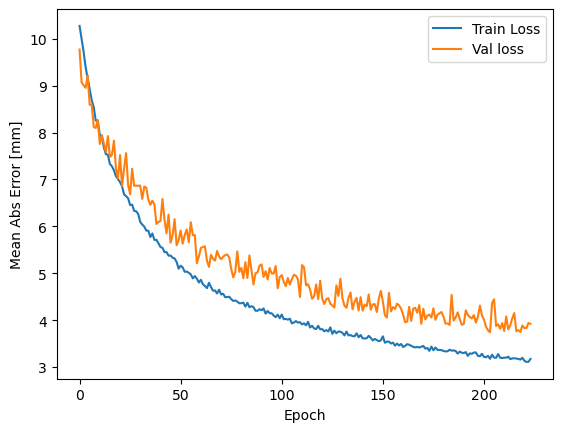

In [21]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(X_train, y_train, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [29]:
# Calculate MAE separately
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae} millimeters")

637/637 [==============================] - 0s 628us/step
Mean Absolute Error on Test Set: 1.1262069481053627 millimeters


637/637 [==============================] - 0s 581us/step


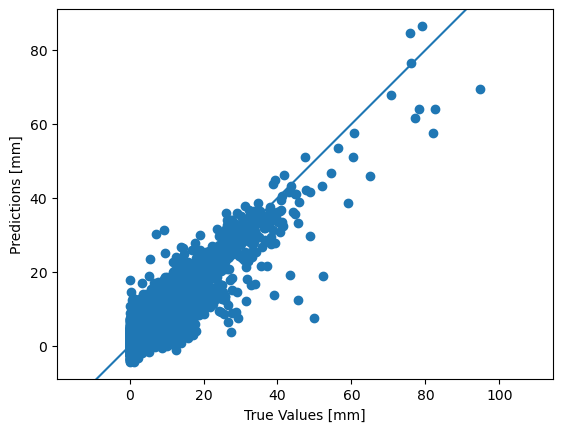

In [24]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [25]:
np.corrcoef(y_test,test_predictions)[0,1]

0.9211378742798222

In [26]:
from sklearn.metrics import r2_score
r2_score(y_test,test_predictions)

0.8484118981514638

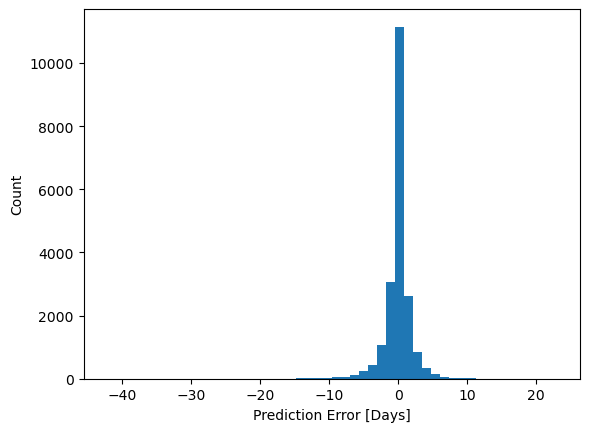

In [27]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [Days]")
_ = plt.ylabel("Count")

In [ ]:
#ATTEMPT for hyperparameter optimization and cross validation, require keras classifier binary label?

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
# Step 3: Define the grid search parameters
param_grid_1 = dict(batch_size=[10, 40, 80], epochs=[10, 50])
print(param_grid_1)

{'batch_size': [10, 40, 80], 'epochs': [10, 50]}


In [15]:
# Step 4: Perform the grid search
grid_1 = GridSearchCV(estimator=model, param_grid=param_grid_1, n_jobs=1)
grid_result_1 = grid_1.fit(X_train, y_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7fa6671bb190> does not.

In [ ]:
# Step 5: Summarize the results
def summarize_results(grid_result):
    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']
    print('Results')
    for mean, param in zip(means, params):
        print(f'{param} -- {mean.round(3)}')
    print('')
    print(f'Best: {grid_result.best_score_.round(3)} using {grid_result.best_params_}')
summarize_results(grid_result_1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
# Define your neural network model as a function
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Create a KerasClassifier model using your model definition function as an argument
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

In [ ]:
#if running again this clears old column
if 'BIODEGRADATION_HALF_LIFE_DAYS_DAYS_CATEGORIES' in df.columns:
    df= df.drop(labels='BIODEGRADATION_HALF_LIFE_DAYS_DAYS_CATEGORIES', axis=1)
#add a new column to df for halflife category low (between 0 and 3.9), medium (greater than 3.9 up to 4.5), high (greater than 4.5 up to 9). 
category = pd.cut(df['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED'], 3)
df.insert(3,'BIODEGRADATION_HALF_LIFE_DAYS_DAYS_CATEGORIES',category)
#df['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_BINARY'] = np.where(df['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED']>4.5, 1, 0)
y= df['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_CATEGORIES']
#print(y)
#Analyzes category distribution
df['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_CATEGORIES'].value_counts(normalize=True)

In [ ]:
# Evaluate your model using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(model, train_data, y, cv=kfold)

In [ ]:
# Print the results
print(f'10-fold cross validation scores:')
for result in results: print('\t', result.round(3))
print('', f'mean: {results.mean().round(3)}', sep='\n')